## Summary

This tutorial uses napari 0.4.15.<br>

Plugins referenced:
- [napari-pyclesperanto-assistant](https://www.napari-hub.org/plugins/napari-pyclesperanto-assistant)
- [napari-blob-detection](https://www.napari-hub.org/plugins/napari-blob-detection)

[Dataset](https://sites.google.com/view/lmrg-image-analysis-study):<br>
[FISH in C. elegans](https://drive.google.com/file/d/1GGU38RmXEIpC01h5Pok3t3J6V67TZqAt/view?usp=drive_web)<br>
Voxel size (x,y,z): 0.162x0.162x0.200 um

Analysis goals:
- Centroid location in microns (um) for each spot
- Integrated Intensity

Steps:
- Open image file
- Crop image (to speed up testing)
- Remove background
- Remove noise
- Points detection
- Output centroid location in microns
- Output center intensity
- Output integrated intensity

Additional resources:<br>
https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/intro.html

## Open image file

Images are in tiff format, can be opened by napari without additional reader plugins.
Images saved locally in the folder '/Users/cchiu/Desktop/images/ABRF/FISH/'

In [1]:
from os import listdir
from os.path import isfile, join
mypath = '/Users/cchiu/Desktop/images/ABRF/FISH/'
files = [join(mypath, f) for f in listdir(mypath)]
print(files)

['/Users/cchiu/Desktop/images/ABRF/FISH/fish4_celegans_dyn-10_ceff-90_final.ics.ome.tiff', '/Users/cchiu/Desktop/images/ABRF/FISH/.DS_Store', '/Users/cchiu/Desktop/images/ABRF/FISH/fish2_celegans_dyn-90_ceff-90_final.ics.ome.tiff', '/Users/cchiu/Desktop/images/ABRF/FISH/fish1_celegans_dyn-90_ceff-0_final.ics.ome.tiff', '/Users/cchiu/Desktop/images/ABRF/FISH/fish3_celegans_dyn-10_ceff-0_final.ics.ome.tiff']


In [2]:
import napari
from napari.utils import nbscreenshot
from tifffile import imread

fish1 = imread(files[3])
print(files[3])
#crop the image for faster processing
fish1 = fish1[40:50,100:300,100:300]

viewer = napari.view_image(fish1, name='original')
viewer.dims.ndisplay = 3
print("file dimension: (z,y,x)",viewer.layers['original'].data.shape)

/Users/cchiu/Desktop/images/ABRF/FISH/fish1_celegans_dyn-90_ceff-0_final.ics.ome.tiff


/opt/anaconda3/envs/napari-blob/lib/python3.10/site-packages/napari_tools_menu/__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


file dimension: (z,y,x) (10, 200, 200)


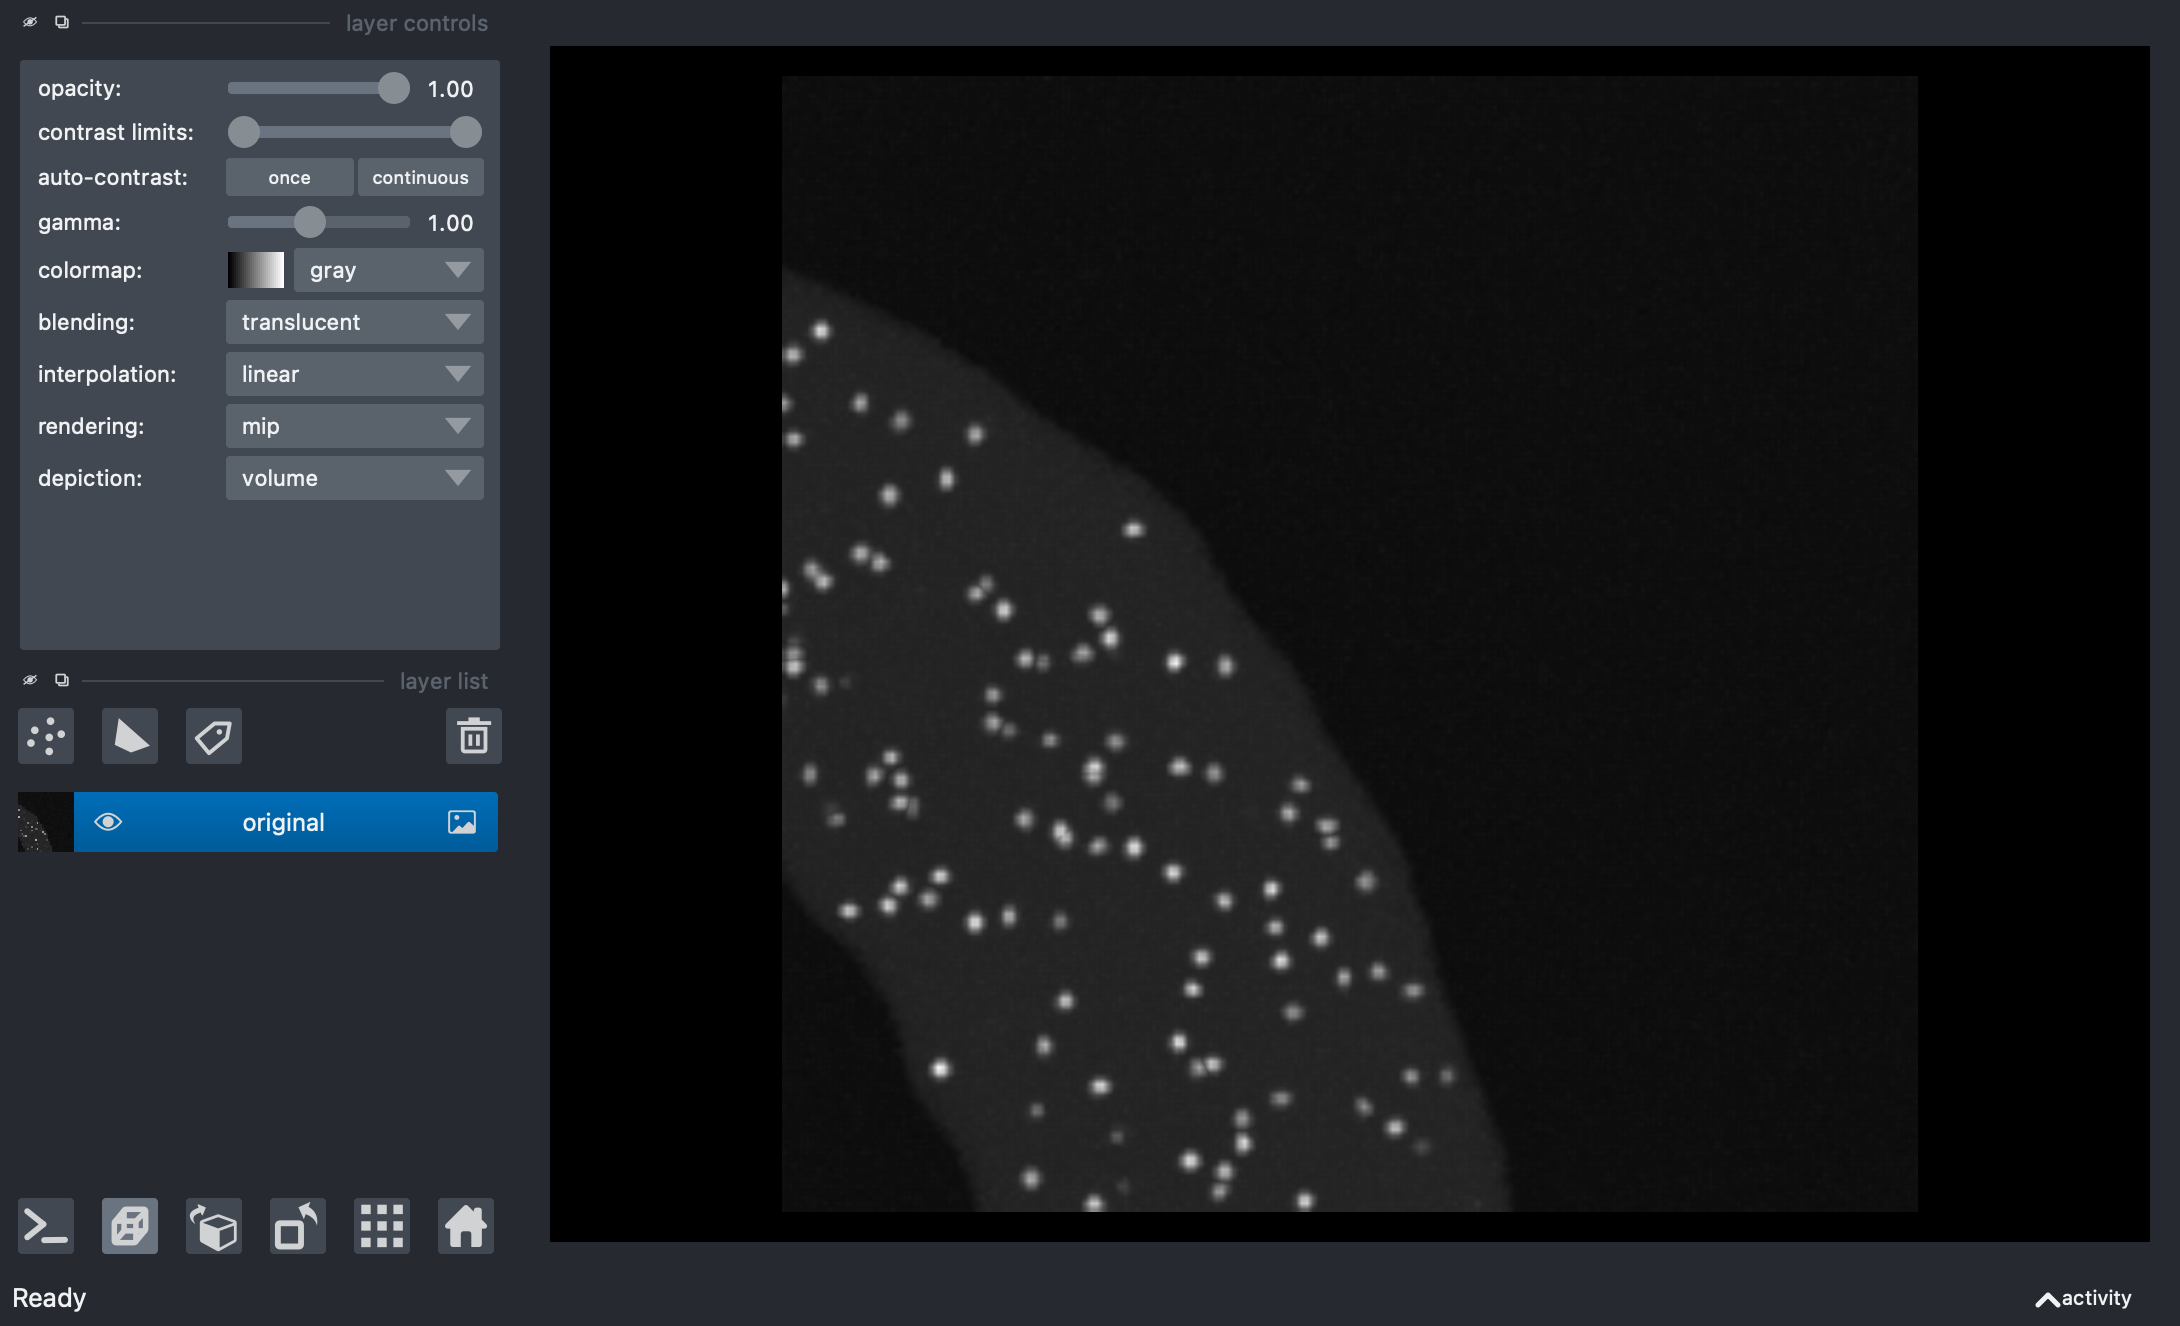

In [3]:
nbscreenshot(viewer)

## Remove background

*Optional for high signal to noise ratio images 

Use skimage.morphology.white_tophat

The white top hat of an image is defined as the image minus its morphological opening. This operation returns the bright spots of the image that are smaller than the footprint.

Also available in [napari-pyclesperanto-assistant](https://www.napari-hub.org/plugins/napari-pyclesperanto-assistant) plugin. 

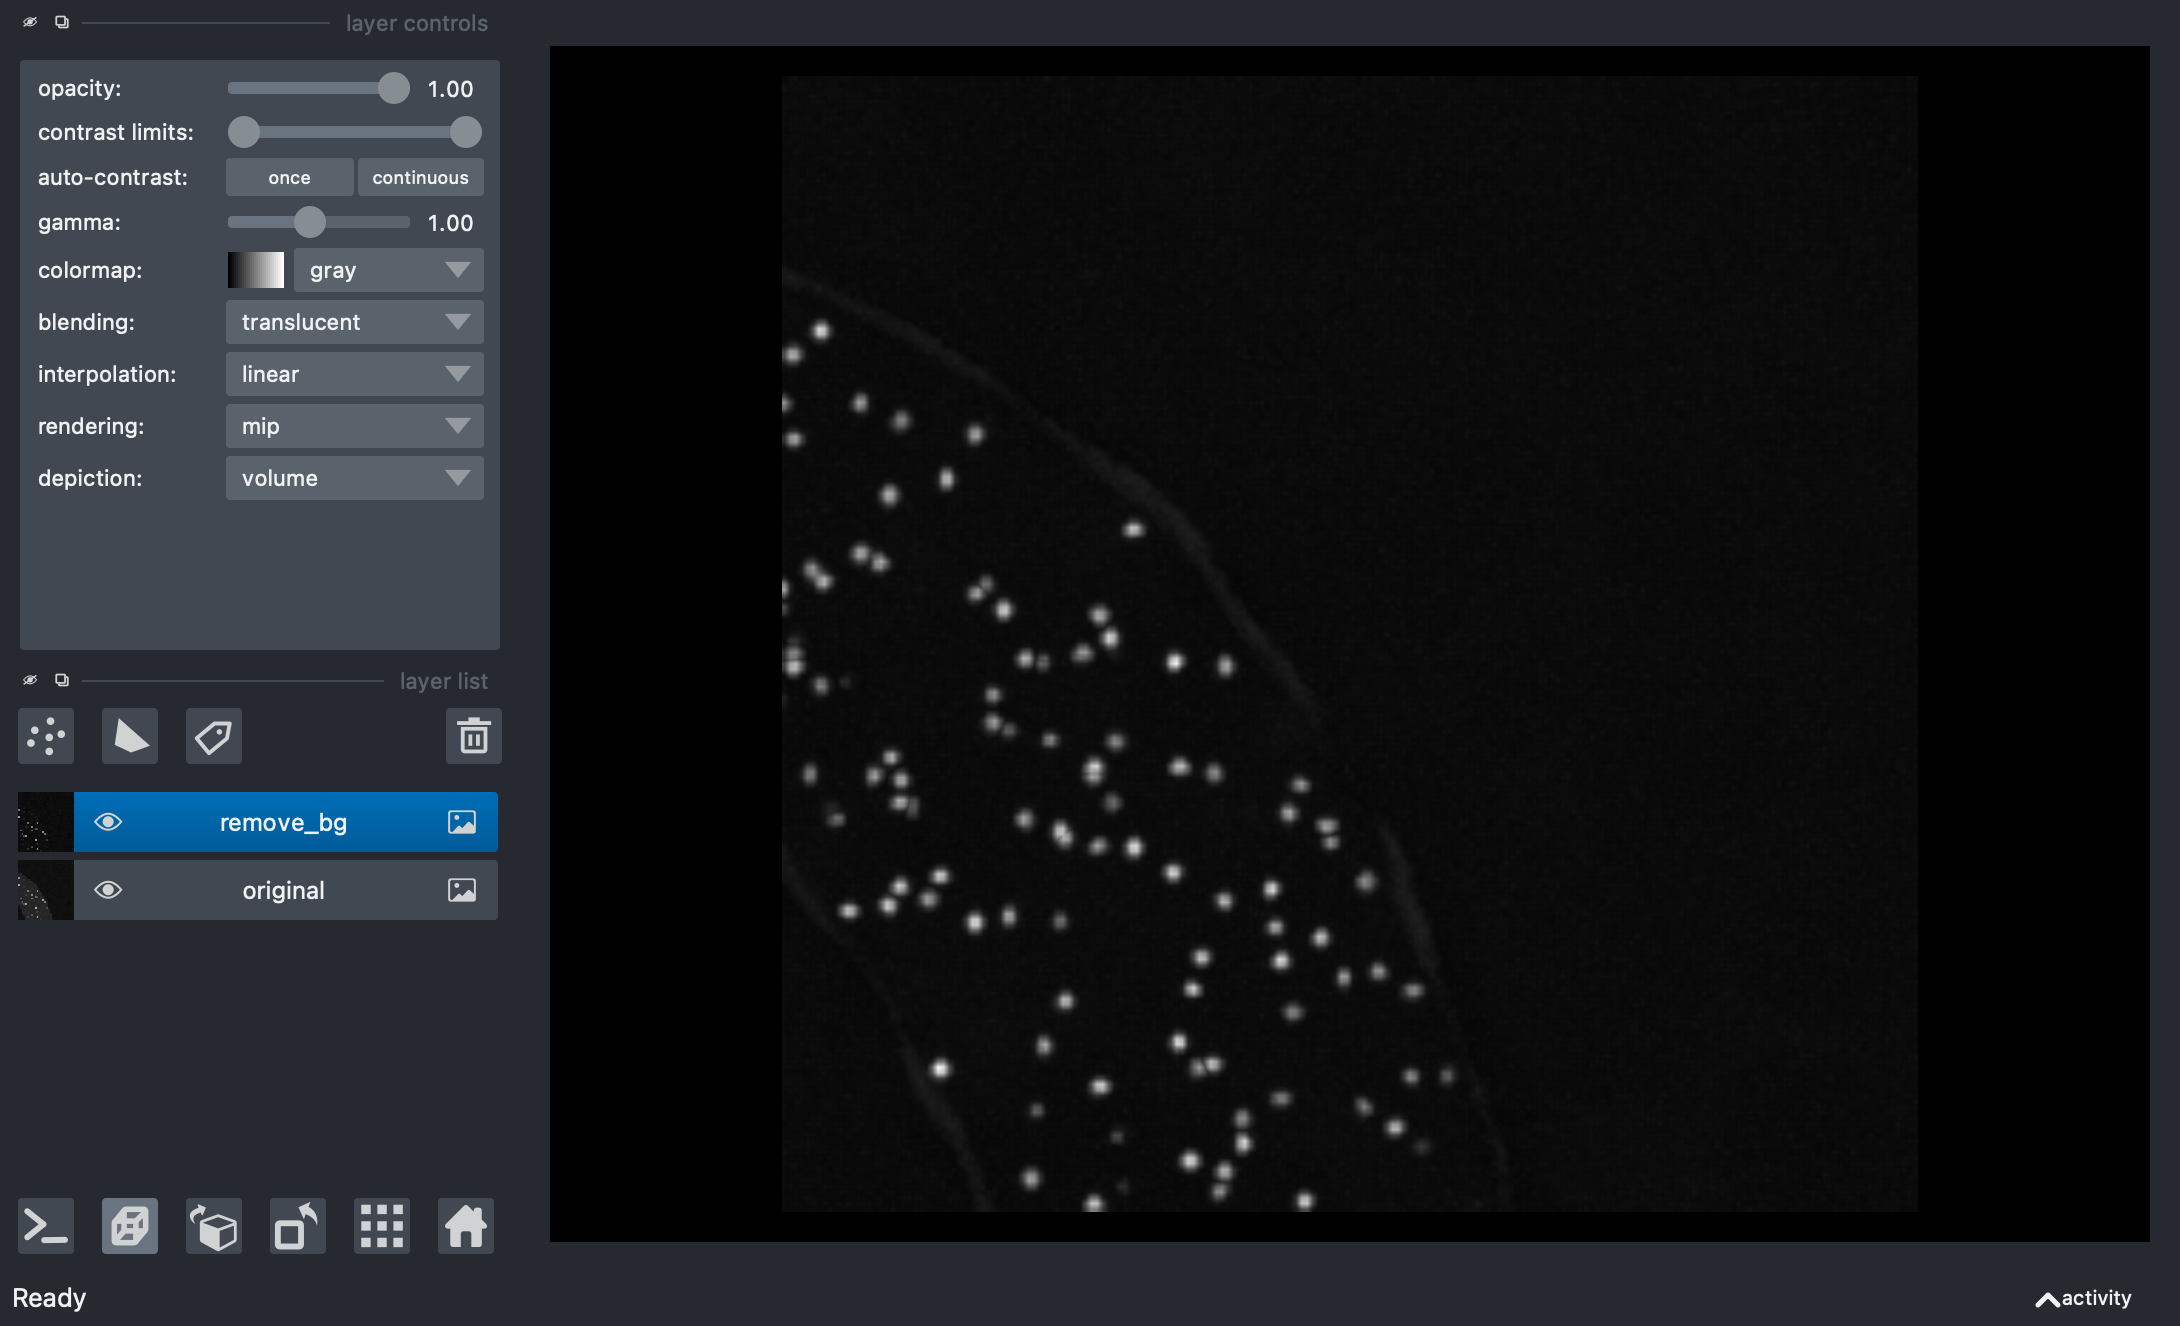

In [4]:
from skimage.morphology import white_tophat, ball
bg_subtracted_image = white_tophat(fish1, ball(10))

viewer.add_image(bg_subtracted_image, name='remove_bg')
nbscreenshot(viewer)

## Remove noise

*Optional for high signal to noise ratio images 

Use skimage.filters.median

Also available in [napari-pyclesperanto-assistant](https://www.napari-hub.org/plugins/napari-pyclesperanto-assistant) plugin. 

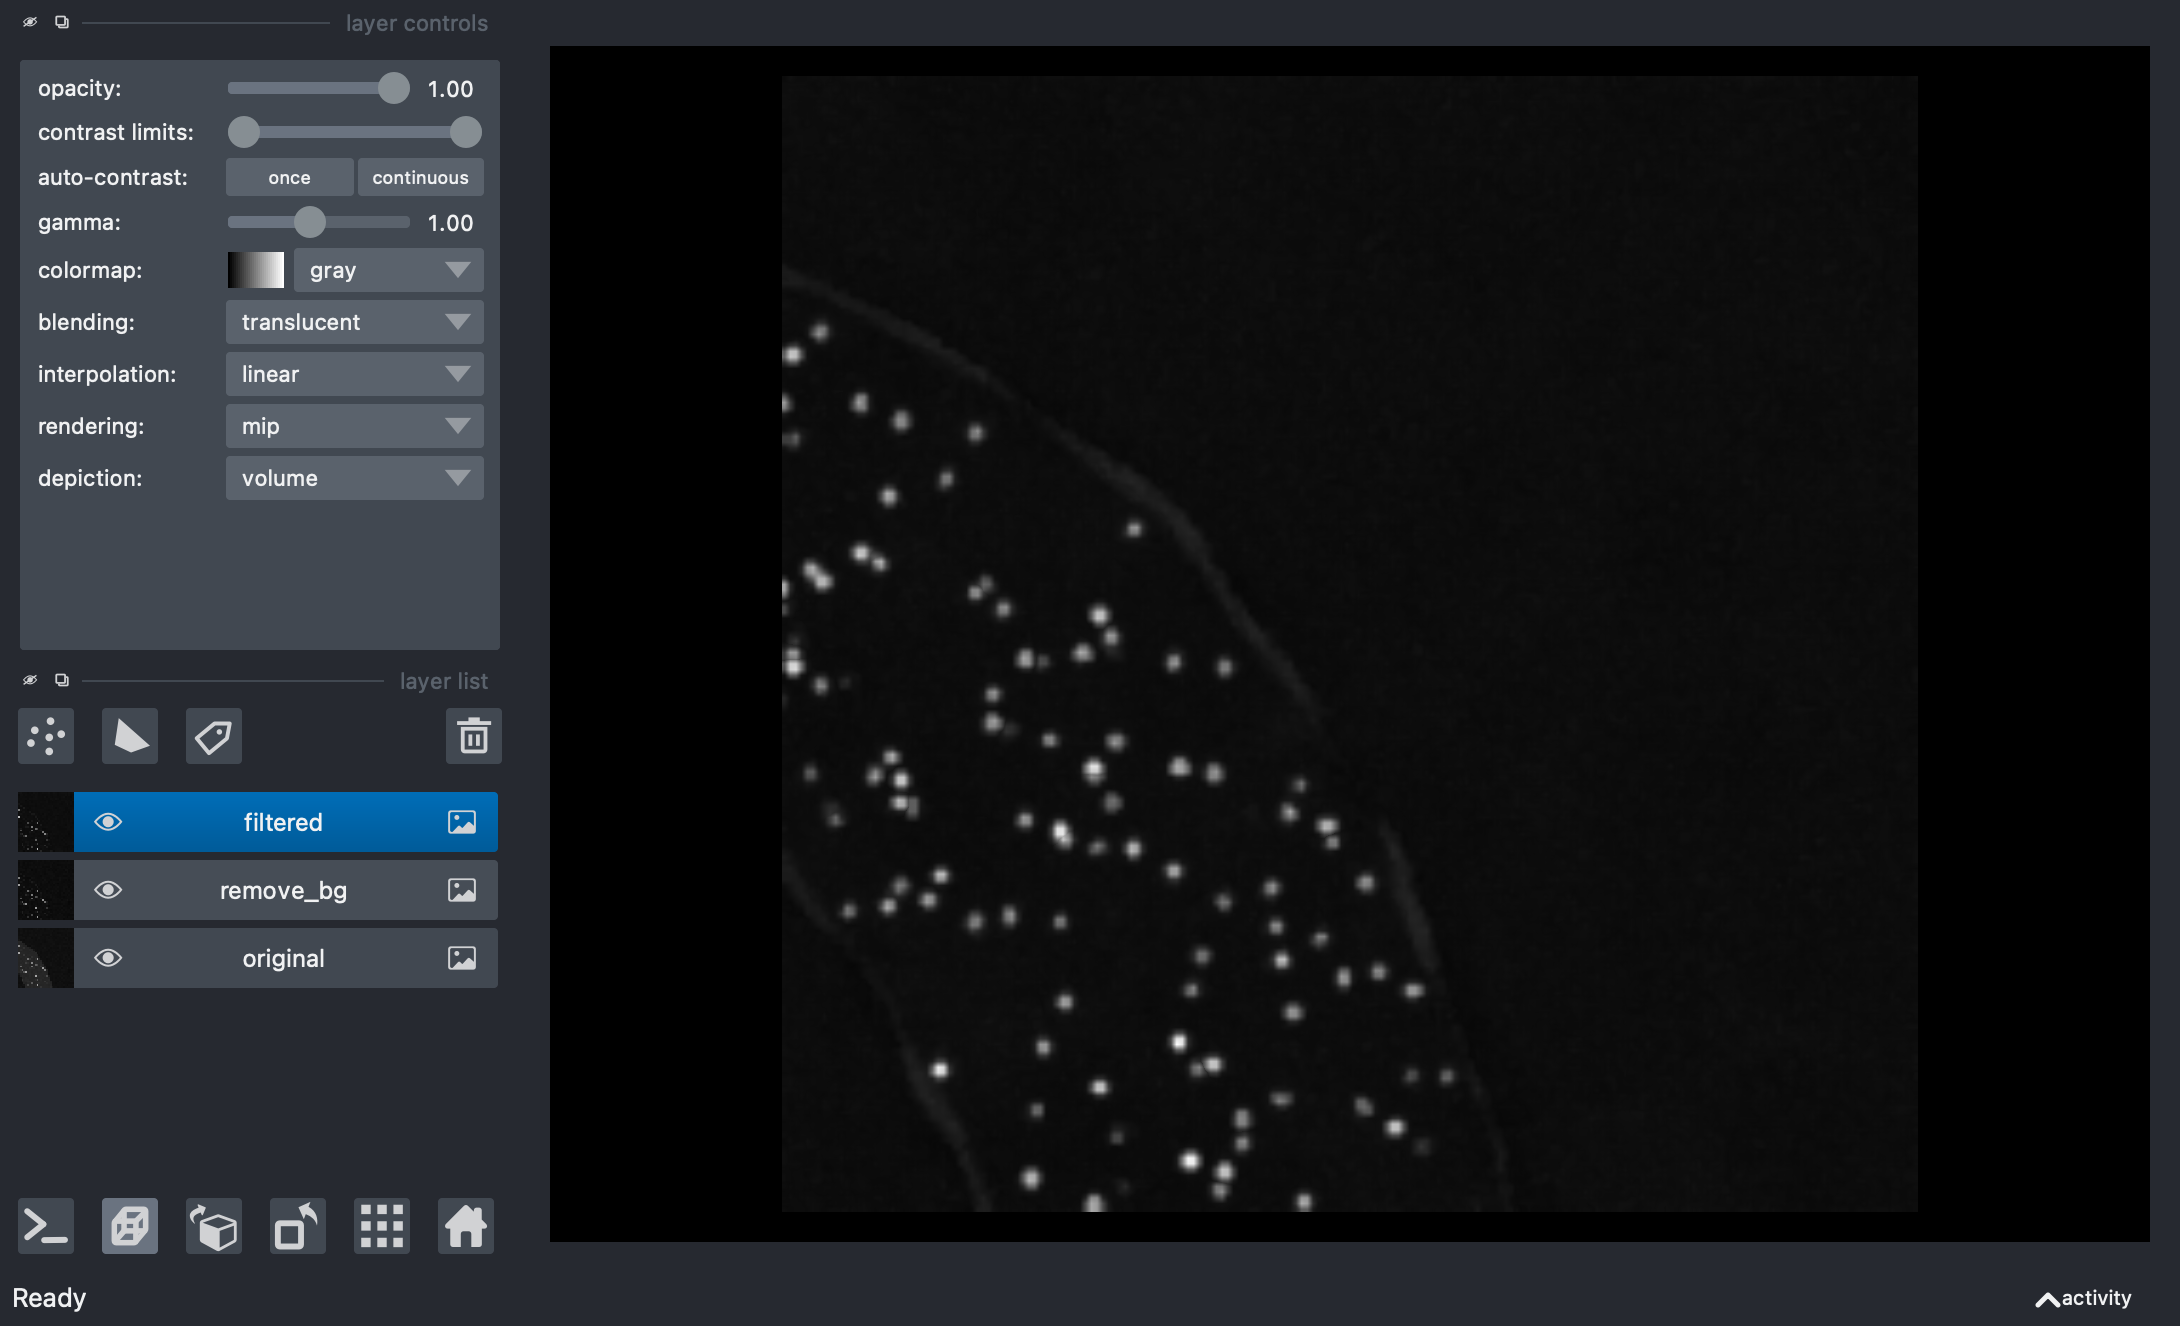

In [5]:
from skimage.filters import median
median_filtered = median(bg_subtracted_image,ball(1))
viewer.add_image(median_filtered, name='filtered')
nbscreenshot(viewer)

## Points detection

(1) Use skimage.feature.blob_log to detect points in membrane channel <br>
(2) Add points layer named "FISH" <br>

parameter note:
- min_sigma=1, max_sigma=5

- threshold = 0.05 for fish1/2 (high SNR)
- threshold = 0.01 for file3/4 (low SNR)

Also available in [napari-blob-detection](https://www.napari-hub.org/plugins/napari-blob-detection) plugin.

In [6]:
from skimage.feature import blob_log, blob_dog
import numpy as np
import time

#measure time difference between log and dog algorithms
start_time = time.time()

blobs = blob_log(median_filtered, min_sigma=1, max_sigma=5,threshold=0.05)
print("--- %s seconds for log---" % (time.time() - start_time))

start_time = time.time()

blobs2 = blob_dog(median_filtered, min_sigma=1, max_sigma=5,threshold=0.05)
print("--- %s seconds for dog---" % (time.time() - start_time))

#returns coordinates + sigma, only keep coordinates
points = blobs[:,:-1]
points2 = blobs2[:,:-1]

#add point size
all_sigmas = blobs[:,-1]
all_sigmas2 = blobs2[:,-1]

viewer.add_points(points, 
        name='FISH', 
        size=np.sqrt(3)*np.array(all_sigmas),
        face_color='red',
        opacity=0.5,
        features={'sigma': all_sigmas})

viewer.add_points(points2, 
        name='FISH_dog', 
        size=np.sqrt(3)*np.array(all_sigmas2),
        face_color='green',
        opacity=0.5,
        features={'sigma': all_sigmas2})

print("total points detected with log:", points.shape[0])
print("total points detected with dog:", points2.shape[0])
print("min point size with log:", np.sqrt(3)*min(all_sigmas))
print("max point size with log:", np.sqrt(3)*max(all_sigmas))
print("min point size with dog:", np.sqrt(3)*min(all_sigmas2))
print("max point size with dog:", np.sqrt(3)*max(all_sigmas2))

--- 0.6447060108184814 seconds for log---
--- 0.16141724586486816 seconds for dog---
total points detected with log: 97
total points detected with dog: 91
min point size with log: 1.7320508075688772
max point size with log: 1.7320508075688772
min point size with dog: 1.7320508075688772
max point size with dog: 1.7320508075688772


/opt/anaconda3/envs/napari-blob/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/opt/anaconda3/envs/napari-blob/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


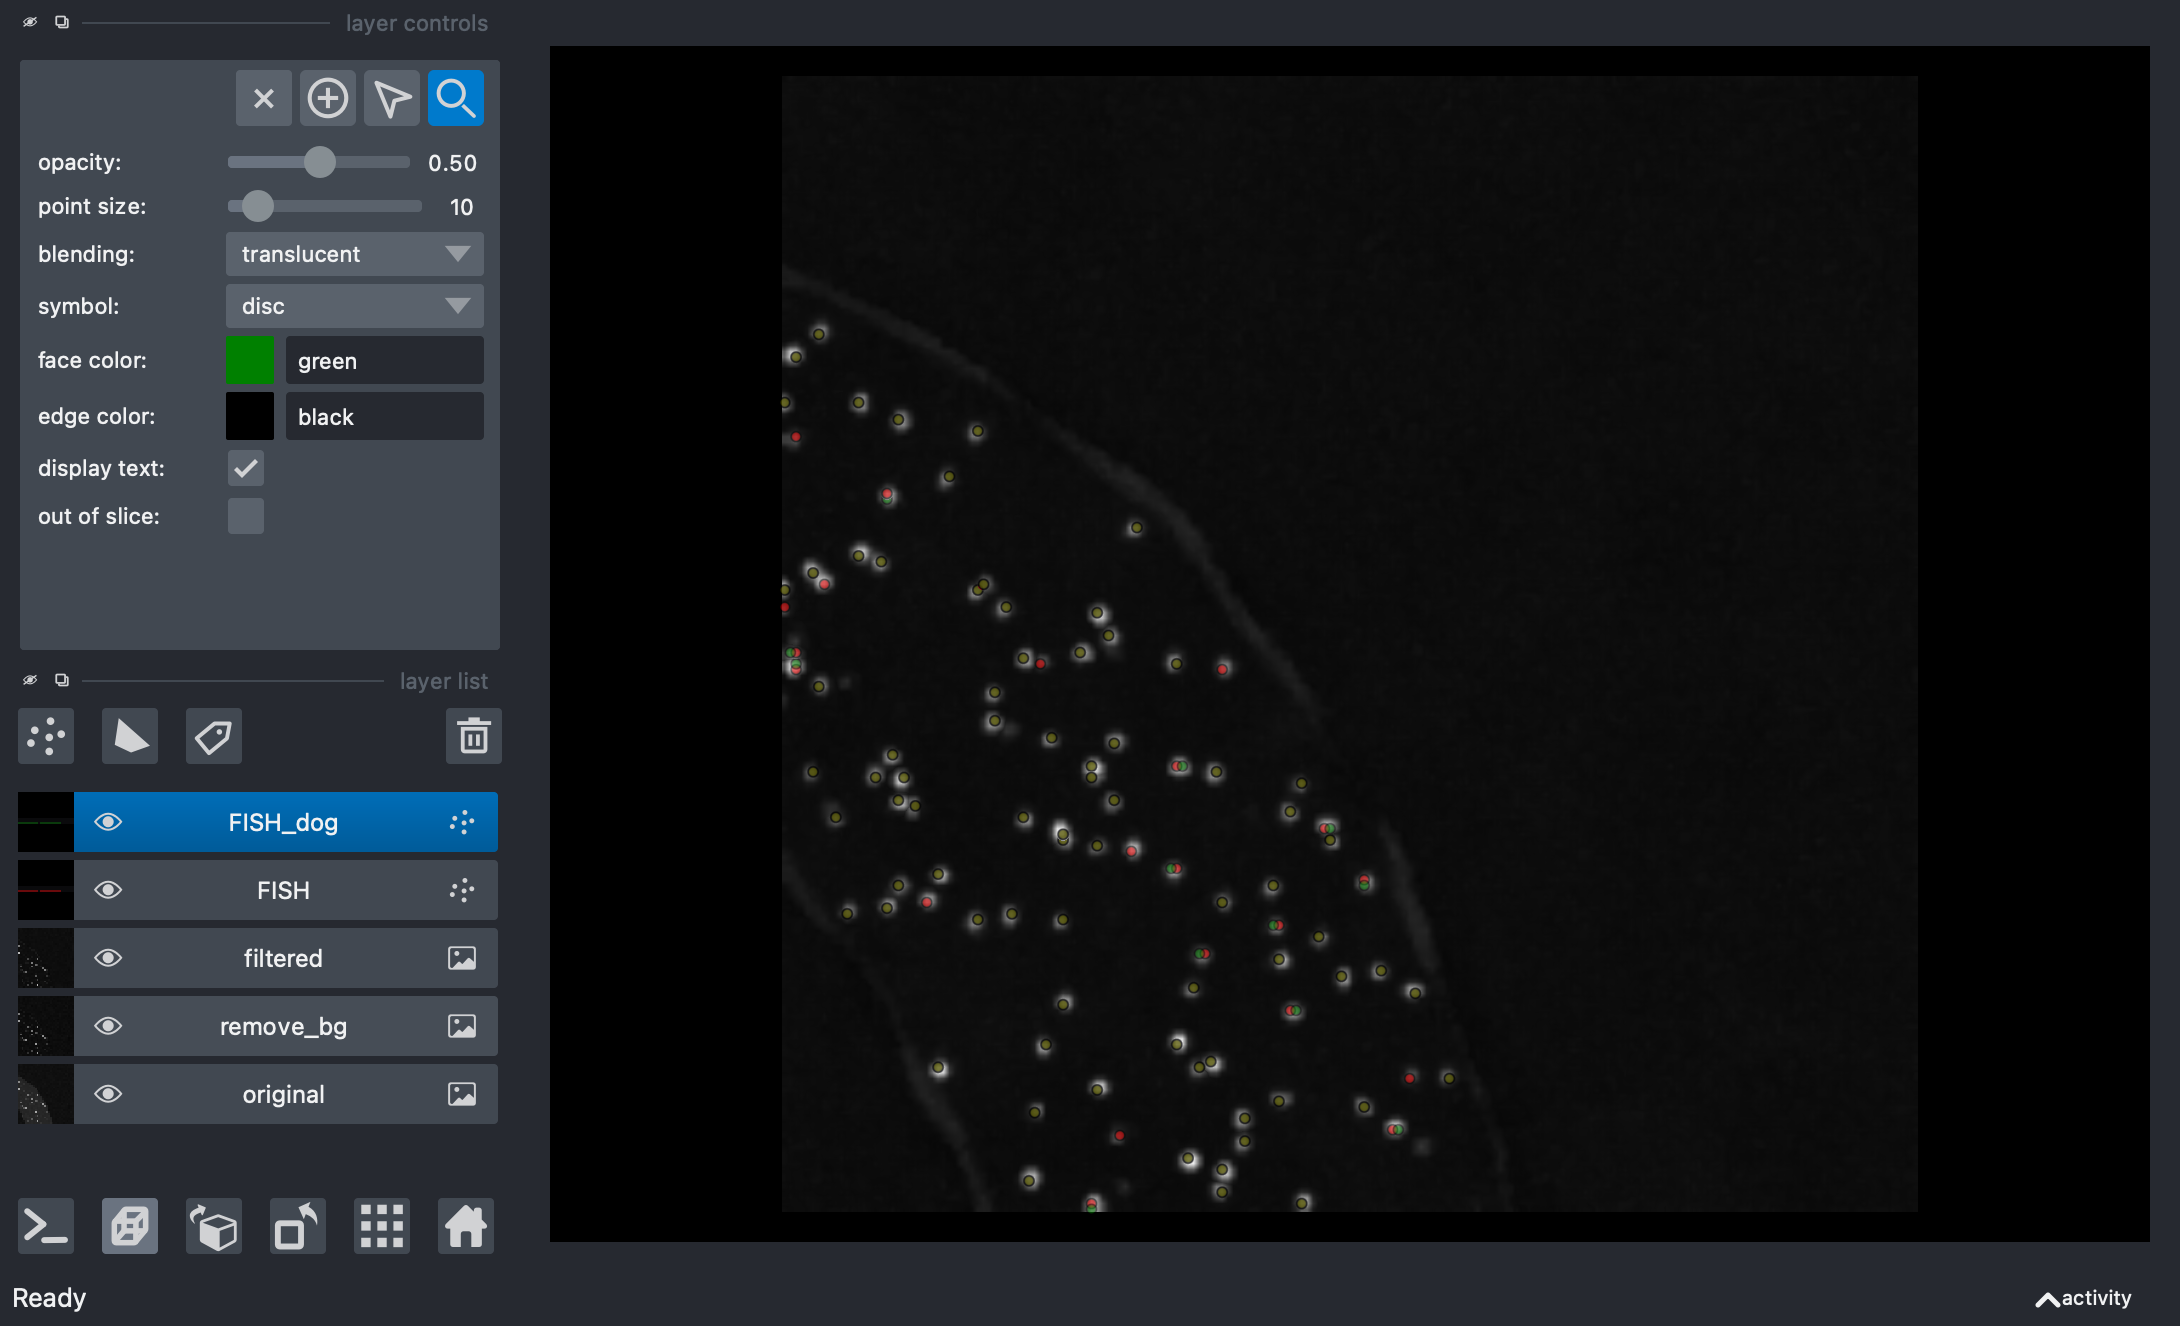

In [7]:
nbscreenshot(viewer)

## Output centroid location in um


Thus far, images and points are calculated and recorded in voxels. <br>
Apply voxel size to convert voxels into physical units, and export centroid location results to csv.

Note napari takes (z,y,x) when assigning dimension.

In [8]:
import pandas as pd

pixel_size = np.array([0.2,0.162,0.162])
original = viewer.layers['FISH'].data
scaled = original*pixel_size

pd.DataFrame(original).to_csv('/Users/cchiu/Desktop/images/ABRF/result/original.csv')
pd.DataFrame(scaled).to_csv('/Users/cchiu/Desktop/images/ABRF/result/scaled.csv')

## Output intensity (1)

By converting points to labels, we can extract the integrated intensity using skimage.measure.regionprops.

(1) Convert points to binary mask <br>
(2) Mask to labels <br>
(3) Use regionprops to extract centroid and intensity <br>

In [9]:
# points to labels
from skimage.morphology import label
mask = viewer.layers['FISH'].to_mask(shape=viewer.layers['original'].data.shape)
viewer.add_labels(label(mask), name='FISH_label')

#get intensity measurement
from skimage.measure import regionprops_table

properties = ['centroid', 'intensity_mean', 'area']

cell_table = pd.DataFrame(
    regionprops_table(viewer.layers['FISH_label'].data, 
    intensity_image=viewer.layers['original'].data,
    properties=properties)
    )
display(cell_table)

centroid-0  centroid-1  centroid-2  intensity_mean  area
0          0.0        57.0         0.0         34046.0     1
1          0.0        60.0        20.0         30891.0     1
2          0.0        84.0        13.0         36836.0     1
3          0.0        90.0         0.0         37878.0     1
4          0.0       101.0        52.0         35422.0     1
..         ...         ...         ...             ...   ...
92         9.0       181.0       102.0         32685.0     1
93         9.0       183.0        81.0         33654.0     1
94         9.0       185.0       107.0         41100.0     1
95         9.0       186.0        59.0         21357.0     1
96         9.0       198.0        54.0         44007.0     1

[97 rows x 5 columns]

## Ouput intensity (2)

Without converting to labels, we can get the centroid intensity from points.

In [10]:
intensity = np.zeros(viewer.layers['FISH'].data.shape[0])
i = 0

for z,y,x in viewer.layers['FISH'].data:
    intensity[i] = viewer.layers['original'].data[int(z),int(y),int(x)]
    i+=1

#add intensity as a feature of the points layer.    
viewer.layers['FISH'].features['intensity'] = intensity

In [11]:
intensity_table = pd.DataFrame(
    viewer.layers['FISH'].data,
    viewer.layers['FISH'].features['intensity']
)
display(intensity_table)

0      1      2
intensity                   
46660.0    0.0  170.0   69.0
46370.0    0.0  190.0   71.0
42275.0    9.0  121.0   54.0
43179.0    0.0  133.0   49.0
40806.0    9.0  104.0    2.0
...        ...    ...    ...
38606.0    3.0   63.0    2.0
34318.0    3.0  176.0  110.0
26807.0    6.0  103.0   45.0
21757.0    9.0   93.0    0.0
21357.0    9.0  186.0   59.0

[97 rows x 3 columns]

## Alternatively, apply image segmentation and bypass Points layer

This method may work with high SNR images (0,1,2) but fails with low SNR images (3)

In [12]:
from skimage.filters import threshold_otsu
thresh = threshold_otsu(median_filtered)
binary = median_filtered > thresh

from skimage.measure import label
seg = label(binary)
viewer.add_labels(seg, name='FISH_seg')
print("total number of objects:",np.max(np.unique(seg)))

total number of objects: 94
